In [1]:
import sys
import numpy as np
import pandas as pd 
import tensorflow_probability as tfp
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
sys.path.append("/home/mindy/Documents/projects/creditCardFraud/scripts/")

In [2]:
tfk = tf.keras
tfkl=tf.keras.layers
tfpl= tfp.layers         # layers for tensor flow probability 
tfd = tfp.distributions # distribution layer 

In [3]:
from util import *
%load_ext autoreload
%autoreload 2

In [4]:
# make sure GPU is running 
tf.test.gpu_device_name()

'/device:GPU:0'

## Import training and dev data and convert to numpy array for NN 

In [5]:
train = pd.read_csv("../processedData/TrainingData_normal.csv").values
dev = pd.read_csv("../processedData/DevData_normal.csv").values

### converting into tf data set to allow simple efficient data pipelines. 
* In autoencoder, you are predicting the original input x 
* shuffle and train data in batches with 1000 epochs 

In [6]:
buffer_size = 10000
batch_size = 256
epochs = 200
input_size = train.shape[1]
encoded_size = 3

In [7]:
train = tf.data.Dataset.from_tensor_slices((train,train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(buffer_size)
dev = tf.data.Dataset.from_tensor_slices((dev,dev)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(buffer_size)

### set up checkpoint and other settings 

In [8]:
checkpoint = tfk.callbacks.ModelCheckpoint("../savedModels/VariationalEncoderModel.h5",verbose=1,save_best_only=True)
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss", mode="min", min_delta=0.001, patience=20, verbose=1, restore_best_weights=True)

### For variational autoencoder we need to maximize ELBO (evidence lower bound objective):

$$ELBO(x)= \int dzq(z|x)logp(x|z) + \int dzq(z|x)log\frac{q(z|x)}{p(z)} $$

* p(z): the prior on the latent representation z (last layer of encoder) 
* q(z|x_input): the encoder (how likely is z given x_input)
* p(x_hat|z): the decoder (how likely is x_hat given z) 
* $\int dzq(z|x)logp(x|z)$: reconstructin term. (how likely for us to get output_x given input_x and encode to z then decode to x_output) 
* $\int dzq(z|x)log\frac{q(z|x)}{p(z)} $: KL divergence. How similar are the encoder distribution and the prior distribution. 

### Prior distribution for z: 

* Since this is latent representation (noise has been removed), it is okay to assume multivariate normal distribution with non zero covariance (features are not independent) 

In [7]:
prior = tfd.MultivariateNormalDiag(loc=tf.zeros([encoded_size]),
                                  scale_identity_multiplier=1.0)

## encoder model for autoencoder:
* encoder: 3 layers:
  * 3 dense layers 
  * 3 dimensional multivariable non zero covariance normal distribution

In [8]:
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape = 30),  # 30 input features 
    tfkl.Dense(units=20, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(units=10, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(units=7, activation =tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(encoded_size),activation=None),
    tfpl.MultivariateNormalTriL(encoded_size,activity_regularizer=tfpl.KLDivergenceRegularizer(prior))
    ], name="encoder")
encoder.summary()    

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 77        
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 72        
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 3), (None, 3))    0         
Total params: 979
Trainable params: 979
Non-trainable params: 0
_________________________________________________________________


## decoder model for autoencoder:
* decoder: 3 layers:
   * 3 dense layers
   * independent normal distributions as output 

In [9]:
decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[encoded_size]),
    tfkl.Dense(units=7, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(units=10, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(units=20, activation=tf.nn.leaky_relu, activity_regularizer=tfk.regularizers.l1(10e-5)),
    tfkl.Dense(tfpl.IndependentNormal.params_size(input_size),activation=None),
    tfpl.IndependentNormal(input_size)
    ], name = "decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 7)                 28        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                80        
_________________________________________________________________
dense_6 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_7 (Dense)              (None, 60)                1260      
_________________________________________________________________
independent_normal (Independ ((None, 30), (None, 30))  0         
Total params: 1,588
Trainable params: 1,588
Non-trainable params: 0
_________________________________________________________________


### Add encoders together 


In [10]:
VAE = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]),name="VAE")

In [11]:
VAE.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 20)                620       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 77        
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 72        
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 3), (None, 3))    0         
_________________________________________________________________
decoder (Sequential)         (None, 30)                1588    

### define reconstruction loss

In [12]:
negloglik = lambda x_input, x_output: -x_output.log_prob(x_input)

### compile the model and train model

In [13]:
VAE.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

In [ ]:
history = VAE.fit(train,epochs=epochs,shuffle=True,
                          verbose=1,validation_data=dev,
                          callbacks=[checkpoint,earlystop])

Epoch 1/200
707/711 [============================>.] - ETA: 0s - loss: 57.5664
Epoch 00001: val_loss improved from inf to 42.50559, saving model to ../savedModels/VariationalEncoderModel.h5
711/711 [==============================] - 4s 5ms/step - loss: 57.4811 - val_loss: 42.5056
Epoch 2/200
709/711 [============================>.] - ETA: 0s - loss: 39.1914
Epoch 00002: val_loss improved from 42.50559 to 36.62857, saving model to ../savedModels/VariationalEncoderModel.h5
711/711 [==============================] - 3s 5ms/step - loss: 39.1852 - val_loss: 36.6286
Epoch 3/200
703/711 [============================>.] - ETA: 0s - loss: 36.0949
Epoch 00003: val_loss improved from 36.62857 to 35.79831, saving model to ../savedModels/VariationalEncoderModel.h5
711/711 [==============================] - 4s 5ms/step - loss: 36.0838 - val_loss: 35.7983
Epoch 4/200
707/711 [============================>.] - ETA: 0s - loss: 35.5486
Epoch 00004: val_loss improved from 35.79831 to 35.41450, saving mod

Epoch 30/200
700/711 [============================>.] - ETA: 0s - loss: 33.7280
Epoch 00030: val_loss improved from 33.81993 to 33.78839, saving model to ../savedModels/VariationalEncoderModel.h5
711/711 [==============================] - 4s 5ms/step - loss: 33.7303 - val_loss: 33.7884
Epoch 31/200
711/711 [==============================] - ETA: 0s - loss: 33.6876
Epoch 00031: val_loss improved from 33.78839 to 33.77042, saving model to ../savedModels/VariationalEncoderModel.h5
711/711 [==============================] - 3s 5ms/step - loss: 33.6876 - val_loss: 33.7704
Epoch 32/200
704/711 [============================>.] - ETA: 0s - loss: 33.6655
Epoch 00032: val_loss improved from 33.77042 to 33.68986, saving model to ../savedModels/VariationalEncoderModel.h5
711/711 [==============================] - 3s 5ms/step - loss: 33.6645 - val_loss: 33.6899
Epoch 33/200
700/711 [============================>.] - ETA: 0s - loss: 33.6249
Epoch 00033: val_loss did not improve from 33.68986
711/711

In [16]:
# plot_loss(history)

In [14]:
VAE.load_weights("../savedModels/VariationalEncoderModel.h5")

### create monte carlo to generate output prob score for anomaly prediction

In [17]:
sampling_size = 100

def reconstruction_log_prob(x_input,sampling_size):
    Z = encoder(x_input)
    encoder_samples = Z.sample(sampling_size)  # generate 30 outputs from encoder per input 
    return np.mean(decoder(encoder_samples).log_prob(x_input), axis=0)

In [18]:
test = pd.read_csv("../processedData/hold_outset_moreFraud.csv")

In [19]:
test_tf_data, label = test.drop("Class",axis=1).values, test["Class"]

In [20]:
x_log_prob = reconstruction_log_prob(test_tf_data, sampling_size)

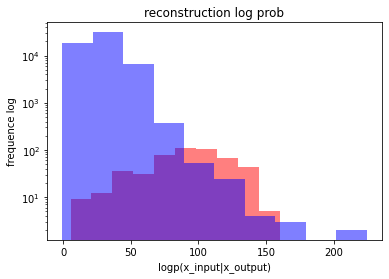

In [21]:
plt.hist(-x_log_prob[label==1],label="fraud",color="red",alpha = 0.5, log=True)
plt.hist(-x_log_prob[label==0],label="normal",color="blue",alpha=0.5, log=True)
plt.title("reconstruction log prob")
plt.ylabel("frequence log")
plt.xlabel("logp(x_input|x_output)")
plt.show()

In [22]:
fpr, tpr, threshold = roc_curve(label,-x_log_prob)
auc = roc_auc_score(label,-x_log_prob)

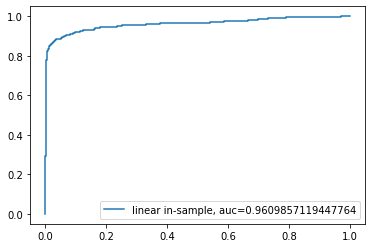

In [23]:
plt.plot(fpr,tpr,label=f"linear in-sample, auc={auc}")
plt.legend(loc="best")
plt.show()

### Choose a threshold that gives a good overall class1 recall 

In [24]:
results = pd.DataFrame({"label":label,"neg_log_prob":-x_log_prob})

In [34]:
results["pred_class"]=results.neg_log_prob.apply(lambda x: 1 if x>76 else 0)

In [35]:
confusion_matrix(results.label,results.pred_class)

array([[56679,   179],
       [  118,   374]])

In [36]:
print(classification_report(results.label, results.pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56858
           1       0.68      0.76      0.72       492

    accuracy                           0.99     57350
   macro avg       0.84      0.88      0.86     57350
weighted avg       1.00      0.99      0.99     57350

